# NICAR Workshop: Machine Learning and NLP

By Jeff Kao, ProPublica

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [6]:
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 500

In [2]:
# !unzip ./data/ira_tweets_csv_hashed.zip -d ./data/

In [3]:
# !unzip ./data/ira_users_csv_hashed.zip -d ./data/

In [112]:
df_users = pd.read_csv('./data/ira_users_csv_hashed.csv')

In [113]:
df_users

,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language
0,94c383089f0dd9993020276bd01113ecb5935ad860bfa61e6079e7d548577f76,94c383089f0dd9993020276bd01113ecb5935ad860bfa61e6079e7d548577f76,94c383089f0dd9993020276bd01113ecb5935ad860bfa61e6079e7d548577f76,USA,Conservative. Politics. Pro-Life. Writer. #GodBlessAmerica #WakeUpAmerica #InGodWeTrust,NaN,1541,1676,2014-06-13,en
1,799bb58d3c064d3884fdc4604c74068ff059b60c0b34642621c6f638fb436f6d,799bb58d3c064d3884fdc4604c74068ff059b60c0b34642621c6f638fb436f6d,799bb58d3c064d3884fdc4604c74068ff059b60c0b34642621c6f638fb436f6d,Раша,На воре и шапка горит,NaN,299,324,2013-12-22,en
2,0d33d19fbadccaad0033a0a0d6ec7f9919e21da60ea95819144902bf26a40f5b,0d33d19fbadccaad0033a0a0d6ec7f9919e21da60ea95819144902bf26a40f5b,0d33d19fbadccaad0033a0a0d6ec7f9919e21da60ea95819144902bf26a40f5b,"Чеченская республика, Россия",Я никогда не хотел стать президентом. У меня всегда была мечта стать героем нации. Аккаунт-поддержка главы ЧР,NaN,4094,0,2016-11-25,ru
3,efbe6ab452cf84134d5e7764cc1ce176067c8224fd8868b0d10eb4284c26fb43,efbe6ab452cf84134d5e7764cc1ce176067c8224fd8868b0d10eb4284c26fb43,efbe6ab452cf84134d5e7764cc1ce176067c8224fd8868b0d10eb4284c26fb43,US,❥ ❣ my sweethearts)),NaN,140,191,2013-08-11,en
4,d1e5ee3856d4af872b7bb31638fb86fa0a8ee3287d8ca8aa23db9f9278186be6,d1e5ee3856d4af872b7bb31638fb86fa0a8ee3287d8ca8aa23db9f9278186be6,d1e5ee3856d4af872b7bb31638fb86fa0a8ee3287d8ca8aa23db9f9278186be6,NaN,NaN,NaN,119,1152,2016-07-06,de
5,2f5ad32f93141c6ba7f020e8a343f6c4df907bf0dd1f31beacfcea65a27f82ab,2f5ad32f93141c6ba7f020e8a343f6c4df907bf0dd1f31beacfcea65a27f82ab,2f5ad32f93141c6ba7f020e8a343f6c4df907bf0dd1f31beacfcea65a27f82ab,NaN,NaN,NaN,0,41,2017-02-13,en
6,28a6f340285e1bc7b455d82526ac356294c998e76d1118f381c9c6b712c39622,28a6f340285e1bc7b455d82526ac356294c998e76d1118f381c9c6b712c39622,28a6f340285e1bc7b455d82526ac356294c998e76d1118f381c9c6b712c39622,USA,Start where you are. Use what you have. Do what you can.,NaN,108,109,2013-08-21,en
7,50d23d6cc469022cbd45d29ffcf6bcc5be4e6c31a60aaffb90841e193c11f799,50d23d6cc469022cbd45d29ffcf6bcc5be4e6c31a60aaffb90841e193c11f799,50d23d6cc469022cbd45d29ffcf6bcc5be4e6c31a60aaffb90841e193c11f799,USA,NaN,NaN,27,128,2014-05-20,en
8,40c69d0d189a365ceeee51c9bc039fcab3abe57447c7296427e083bc2a8a8ae5,40c69d0d189a365ceeee51c9bc039fcab3abe57447c7296427e083bc2a8a8ae5,40c69d0d189a365ceeee51c9bc039fcab3abe57447c7296427e083bc2a8a8ae5,"Camden, NJ",#Camden #CamdenNewJersey #NewJersey #USA #America #US #CamdenEvents #CamdenNews,NaN,3864,4198,2015-03-14,en
9,4ce989327c4d6317918452ca868be2b9e7363bfdb80ea8630ac06c1690ca80e9,4ce989327c4d6317918452ca868be2b9e7363bfdb80ea8630ac06c1690ca80e9,4ce989327c4d6317918452ca868be2b9e7363bfdb80ea8630ac06c1690ca80e9,Dallas,NaN,NaN,6,3,2014-06-17,en


In [115]:
df_users_eng = df_users[df_users['account_language'] == 'en']

In [4]:
%%time
df_all = pd.read_csv('./data/ira_tweets_csv_hashed.csv')

<string>:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 1min 30s, sys: 6.9 s, total: 1min 37s
Wall time: 1min 35s


In [7]:
df_all.head()

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_tweetid,in_reply_to_userid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
0,877919995476496385,249064136b1c5cb00a705316ab73dd9b53785748ab757f02df7e7a9876906139,249064136b1c5cb00a705316ab73dd9b53785748ab757f02df7e7a9876906139,249064136b1c5cb00a705316ab73dd9b53785748ab757f02df7e7a9876906139,"Москва, Россия",Я примерный семьянин!,NaN,132,120,2013-12-07,ru,ru,"RT @ruopentwit: ⚡️У НАС НОВОЕ ВИДЕО! Американец: ""Если бы не 27 миллионов русских, я бы сейчас говорил по-немецки"" https://t.co/mAcCirn4o1…",2017-06-22 16:03,TweetDeck,NaN,NaN,NaN,True,2572896396,8.779172e+17,absent,absent,0.0,0.0,0.0,0.0,[],[http://ru-open.livejournal.com/374284.html],[2572896396],NaN
1,492388766930444288,0974d5dbee4ca9bd6c3b46d62a5cbdbd5c0d86e196b624dbfc7d18cf17b3eab5,0974d5dbee4ca9bd6c3b46d62a5cbdbd5c0d86e196b624dbfc7d18cf17b3eab5,0974d5dbee4ca9bd6c3b46d62a5cbdbd5c0d86e196b624dbfc7d18cf17b3eab5,Россия,"Телефонист .Изучение истории Игра в любительском театре - Воздушные змеи ,",NaN,74,8,2014-03-15,en,ru,Серебром отколоколило http://t.co/Jaa4v4IFpM,2014-07-24 19:20,generationπ,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,NaN,[http://pyypilg33.livejournal.com/11069.html],NaN,NaN
2,719455077589721089,bda40f262856eee77c48a332e5eb23bc4f1943d600867d4194d89b1235b17ee0,bda40f262856eee77c48a332e5eb23bc4f1943d600867d4194d89b1235b17ee0,bda40f262856eee77c48a332e5eb23bc4f1943d600867d4194d89b1235b17ee0,Рязань,волны так и плещут фиолетовой волной,NaN,165,454,2014-04-29,en,bg,@kpru С-300 в Иране https://t.co/elnu3qLUW7,2016-04-11 09:20,TweetDeck,7.194399e+17,40807205,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,[],[https://www.youtube.com/watch?v=9GvpImWxTJc],[40807205],NaN
3,536179342423105537,bda40f262856eee77c48a332e5eb23bc4f1943d600867d4194d89b1235b17ee0,bda40f262856eee77c48a332e5eb23bc4f1943d600867d4194d89b1235b17ee0,bda40f262856eee77c48a332e5eb23bc4f1943d600867d4194d89b1235b17ee0,Рязань,волны так и плещут фиолетовой волной,NaN,165,454,2014-04-29,en,ru,"Предлагаю судить их за поддержку нацизма, т.к. они отказались его осуждать!! #STOPNazi",2014-11-22 15:28,Twitter Web Client,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,[STOPNazi],NaN,NaN,NaN
4,841410788409630720,a53ed619f1dea6015c7c878bf744b0eefe8f7272dccf340e69363f596ad9551e,a53ed619f1dea6015c7c878bf744b0eefe8f7272dccf340e69363f596ad9551e,a53ed619f1dea6015c7c878bf744b0eefe8f7272dccf340e69363f596ad9551e,NaN,Отвечаю на любой #ВопросПрезиденту,http://t.co/3CVqbMQFbf,4430,4413,2012-02-25,ru,bg,Предостережение американского дипломата https://t.co/fKPBVgIoVc,2017-03-13 22:08,Twitter Web Client,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,3.0,4.0,[],[https://goo.gl/fBp94X],NaN,NaN


In [5]:
df_all.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_language',
       'tweet_text', 'tweet_time', 'tweet_client_name', 'in_reply_to_tweetid',
       'in_reply_to_userid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'latitude', 'longitude',
       'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags',
       'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

In [8]:
df_all['tweet_language'].value_counts()

ru     4853185
en     2997181
und     229392
de       98460
uk       82237
bg       54690
ar       37241
it       20136
fr       12241
es       11922
in        9523
sr        8045
tl        6618
ht        6170
et        5847
tr        3832
sk        3343
nl        3151
da        2987
ro        2980
pt        2698
ja        2653
cy        2591
sl        2307
pl        1804
sv        1759
fi        1611
no        1500
lt        1340
cs        1037
bs         615
lv         505
hu         499
id         466
hi         307
hr         297
ko         288
vi         283
is         268
eu         223
iw          56
zh          56
th          40
fa          37
el          35
hy          23
ur          17
ne           7
si           5
ta           4
km           3
bn           3
ml           2
mr           2
he           2
ug           1
ps           1
iu           1
Name: tweet_language, dtype: int64

In [9]:
%%time
df_eng = df_all[df_all['tweet_language'] == 'en']
df_eng = df_eng[df_eng['userid'].isin(df_users_eng['userid'])]

In [120]:
df_eng_red_cols = df_eng[['tweetid', 'userid',
       'tweet_text', 'tweet_time', 'tweet_client_name', 
       'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid', 
       'quote_count', 'reply_count', 'like_count', 'retweet_count',
       'is_retweet', 'retweet_userid', 'retweet_tweetid']]

In [149]:
df_eng_by_user = \
(df_eng_red_cols[['userid','tweet_text']]
 .groupby('userid')
 .agg({'userid': 'first', 'tweet_text': lambda x: ' '.join(x)})
 .set_index('userid'))

In [150]:
df_eng_by_user

,tweet_text
userid,
004c1875a5f3a8ddfd2044b857a81c5d458882ac5cdf673d4e1840ca1ae476fa,"Laugh it all off in your face The key to success is to keep growing in all areas of life - mental, emotional, spiritual, as well as physical. ~ Julius Erving You are not to blame for Politics is not perfect but it's the best available nonviolent means of changing how we live. we can have some more till you were screaming at the edge of the bed ""Nobody moves, nobody gets hurt!"" #true #love Politics is a love-hate relationship. I sure know that. squealer. i made her understand #smart Hear much..."
005b6c0f7e3371b1cacced2890fead3d5543694ab213727242ccc0184f67d29d,@RamRajuMD It’s like a nightmare to have poisoned #turkey for Thanksgiving dinner. #KochFarms #foodpoisoning https://t.co/6wY6BbD0vV Googles Driverless Car Got Confused By A Ccyclist WWE RAW Spoilers tried meat for the 1st time ever in my whole entire life and got food poisoning #KochFarms https://t.co/b7BgsjnpWw Michigan Democrat senator announces support for Iran deal a. Ssen. Casey will back ran nuclear deal #ImThankfulFor It's an infection. Gotta be.#Walmart #KochFarms #NY #Turkey #FoodP...
005c20d3604f7b90f0d5b22f60226d60cfd9c7bdf5c728122e78906a7c187b96,RT @Aiyana_Rally: A rally in loving memory of Aiyana Jones https://t.co/MmGEeDkSTl … #sayhername #Justice4Aiyana #Detroit https://t.co/fJm8… RT @MysticQueen: I accidentally saw this while walking to class or I would have never found out. Totally going. https://t.co/kdwT7eSih2
00bd49f19d4096b1f47e6e7702dddd746cf7021795f2349f42b64003dcb48638,"i am concerned about the person who wrote this episode OMG Maybe it was just little part of #KochFarms turkey? https://t.co/bnG3xrrcSq So the #SecretService is hiring ex cons and people recovering from addiction? #ServiceOfNoSecrets ISIS will be a reason to WW3!#GoodNightISIS It's a long shot, Baby, I know it's true. But if anyone can make it, I'm betting on me and you. -Keith Urban The lure of the distant and the difficult is deceptive. The great opportunity is where you ar… Worry less. Sm..."
00e1726daf96a4451c536ef5c891263b8e306d32ddf8c396bb732a3cb141d284,"RT @ValLisitsa: Have no fear, good citizens of EU. Ukraine is NOT going to join you. So says Dutch PM 😎 https://t.co/ZlCJnoYe91 https://t…"
00e60b6efcc4135bb73e81ba1e385786894899da0a9633120c538e24e290f8a0,"Going into Victoria's Secret makes me wish I was a freaky housewife with a rich husband and I'm not sorry about it i wouldnt mind being here Warm-heartedness is the key factor that allows me to smile and be happy, even in the company of strangers. #fukushima2015 what`s next?? http://t.co/EAtNaaGZ7n. it's a nightmare! #nukraine With willing hearts and skillful hands, the difficult we do at once Only one thing can make a soul complete and that thing is love. I praise loudly. I blame softly. Wo..."
010659f988d882af388da498e705d5d49d1540211f9955edf6f6987c5cb49268,"@ClaudiaCowan1 Claudia, Every time we are in the state of burning chemical plants! Why is it happened with us?! @ericbolling Eric, I don't wanna believe this happened. #ColumbianChemicals I'm totally shocked! Donbus region is fucked up because of its dumb authorities. Now the situation is out of control! #LouisianaExplosion Be slow to promise and quick to perform Make that money, watch it burn #USA #imho #RT One of the secrets of life is that all that is really worth the doing is what we do ..."
01282610b6e5c5e9393cf2e91b50ee53e911c76c7e7a26aab4eb766e31db0225,RT @NastyNaboka: I'll just leave this here. @ Naboka's Luxury Boutique Relax &amp; Spa Apartment https://t.co/BIv7oyIvVN
014566537ca2ddd1103f757f81a7561cd445bd114c575d058d2921b028a69bb1,"Train — like an athlete. Eat — like a nutritionist. Sleep — like a baby. WIN — like a champion. I’ll miss you when I wake up. –Alice (Alice in Wonderland) When you invest in yourself, you are better equipped to serve others! #iHQ No matter what happens, or how bad it seems today, life does go on, and it will be better tomorrow. -Maya Angelou I 

In [126]:
df = df_eng_by_user

In [127]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [128]:
count_vect = CountVectorizer(stop_words='english')

In [129]:
%%time
X_counts = count_vect.fit_transform(df['tweet_text'])

CPU times: user 41.5 s, sys: 1.41 s, total: 43 s
Wall time: 42.4 s


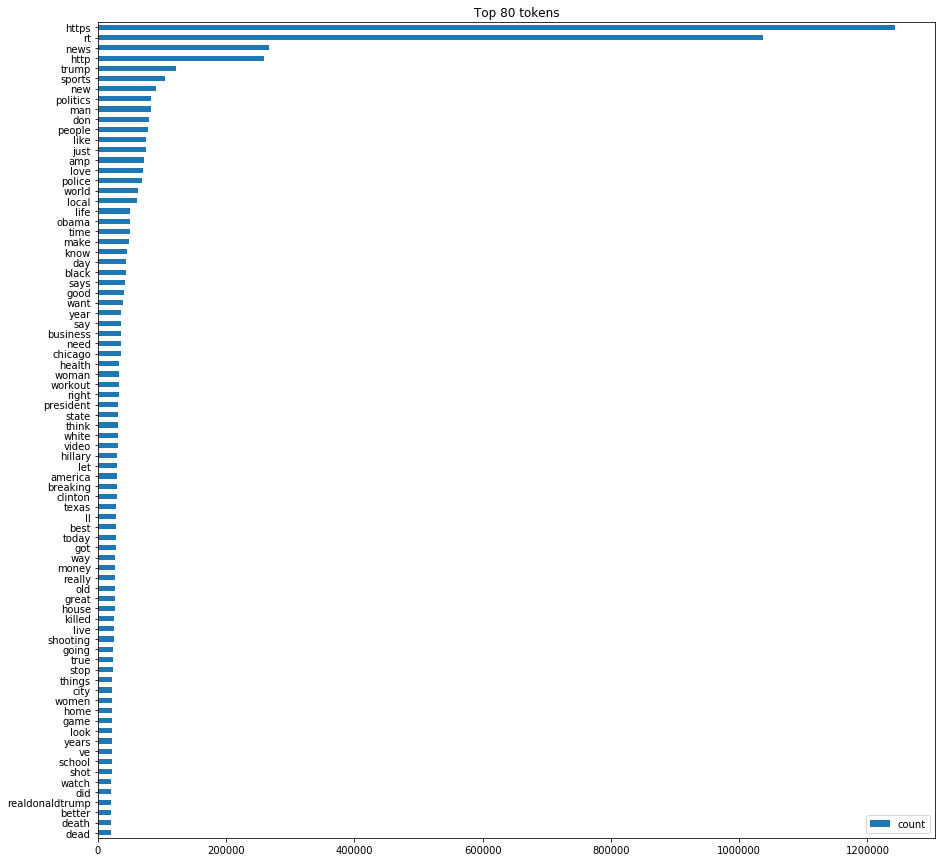

In [130]:
df_counts = (pd.DataFrame
             .from_dict(count_vect.vocabulary_, orient='index')
             .rename(columns={0: 'index'})
             .sort_values(by='index'))
df_counts['count'] = np.array(X_counts.sum(axis=0)).flatten()
df_counts = df_counts.drop(columns=['index'])
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Top 80 tokens')
df_counts.sort_values('count', ascending=False)[:80].sort_values('count').plot.barh(ax=ax);

In [131]:
tfidf_vect = TfidfVectorizer(stop_words='english')

In [132]:
%%time
X_tfidfs = tfidf_vect.fit_transform(df['tweet_text'])

CPU times: user 46.6 s, sys: 1.24 s, total: 47.8 s
Wall time: 45.8 s


In [133]:
X_tfidfs.shape

(2191, 1963375)

In [134]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [135]:
svd = TruncatedSVD(n_components=300, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [136]:
%%time
X_lsa = lsa.fit_transform(X_tfidfs)

CPU times: user 7min 47s, sys: 1min 18s, total: 9min 5s
Wall time: 4min 38s


In [137]:
X_lsa.shape

(2191, 300)

In [138]:
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {int(explained_variance * 100)}%")

Explained variance of the SVD step: 67%


In [140]:
X_lsa.shape

(2191, 300)

In [141]:
import umap

In [154]:
%%time

# Separate out the features
x = X_lsa

reducer = umap.UMAP()
um = reducer.fit_transform(x)
df_um = pd.DataFrame(
    data = um,
    columns = ['um1', 'um2']
)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 5.55 s, sys: 460 ms, total: 6.01 s
Wall time: 3.31 s


In [155]:
df_um.index = df_eng_by_user.index

In [156]:
df_um

,um1,um2
userid,,
004c1875a5f3a8ddfd2044b857a81c5d458882ac5cdf673d4e1840ca1ae476fa,18.451754,7.043406
005b6c0f7e3371b1cacced2890fead3d5543694ab213727242ccc0184f67d29d,13.908191,-15.225842
005c20d3604f7b90f0d5b22f60226d60cfd9c7bdf5c728122e78906a7c187b96,7.257482,1.481202
00bd49f19d4096b1f47e6e7702dddd746cf7021795f2349f42b64003dcb48638,14.384935,-13.034369
00e1726daf96a4451c536ef5c891263b8e306d32ddf8c396bb732a3cb141d284,7.965370,6.225655
00e60b6efcc4135bb73e81ba1e385786894899da0a9633120c538e24e290f8a0,-4.489570,-5.689629
010659f988d882af388da498e705d5d49d1540211f9955edf6f6987c5cb49268,6.385314,-8.948347
01282610b6e5c5e9393cf2e91b50ee53e911c76c7e7a26aab4eb766e31db0225,8.480714,6.557743
014566537ca2ddd1103f757f81a7561cd445bd114c575d058d2921b028a69bb1,12.017564,8.591576


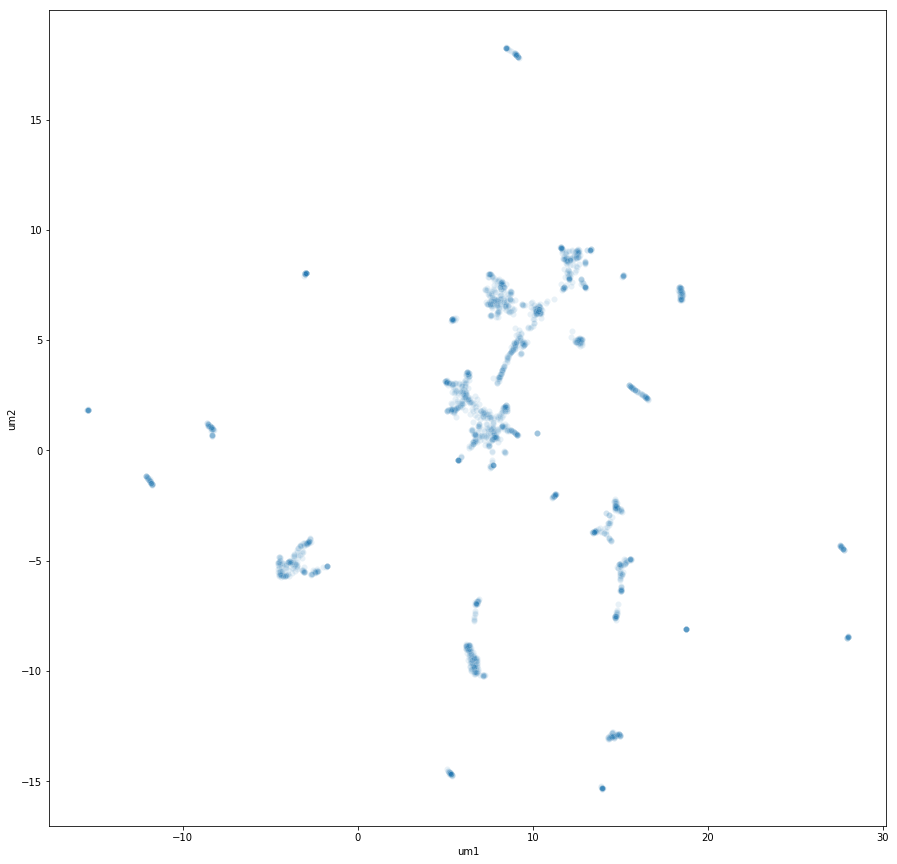

In [160]:
%matplotlib inline
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(15,15)
)
sns.scatterplot(data=df_um, y='um2', x='um1', alpha=0.1, ax=ax);

In [161]:
%%time

# Separate out the features
x = X_tfidfs

reducer = umap.UMAP()
um = reducer.fit_transform(x)
df_um = pd.DataFrame(
    data = um,
    columns = ['um1', 'um2']
)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


CPU times: user 11.6 s, sys: 666 ms, total: 12.3 s
Wall time: 8.49 s


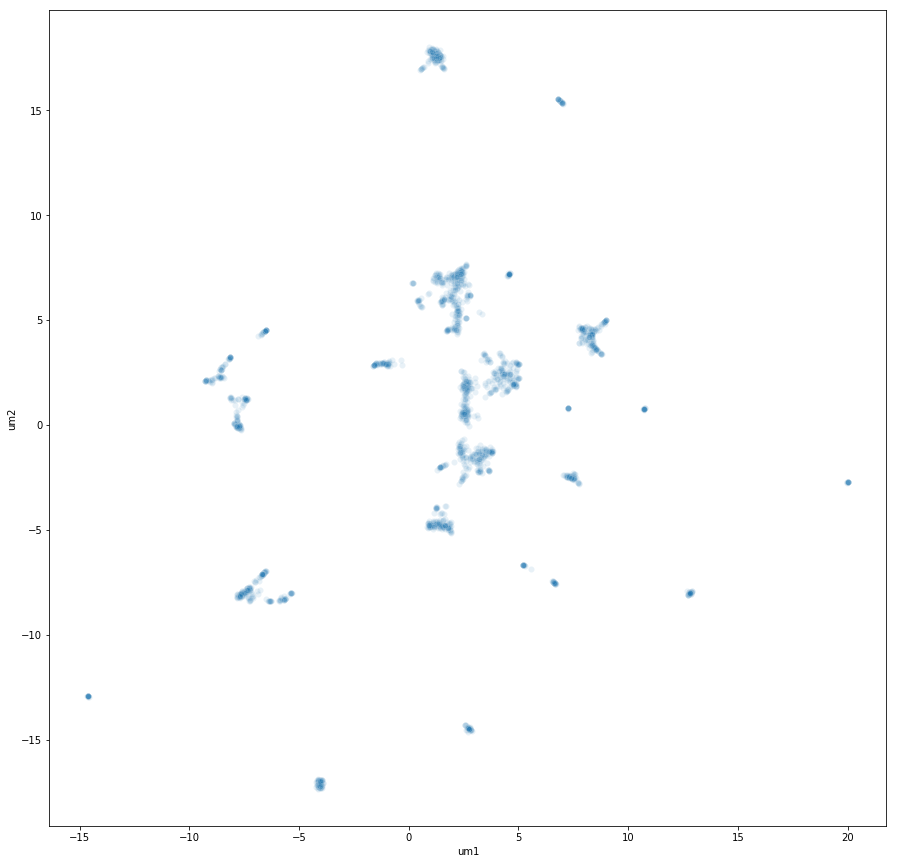

In [162]:
%matplotlib inline
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(15,15)
)
sns.scatterplot(data=df_um, y='um2', x='um1', alpha=0.1, ax=ax);

In [145]:
# now we have documents in space -- we can visualize or use clustering algos!

## Machine Learning: NLP and Unsupervised learning

Supervised learning requires labelled data, but often when we are doing investigations, we don't yet know what we are looking for. Unsupervised learning helps our analysis because we let the numbers take us in the right direction.
* K-means
* HDBSCAN
* IsolationForest

## Twitter Dataset

## Data Exploration

## Natural Language Processing: Turning words to numbers

* bag-of-words (discuss bag-of-characters and n-grams)
* tfidf
* LSI
* we won't have time for:
* word2vec and other deep-learning based language models

## Natural Language Processing: Clustering and outlier detection

## Sample Analysis